## 1. Setup & Installation


# 🏙️ Urban Change Detection Using U-Net Baseline
## Deep Learning Mini Project - Maggie Tu

**Task:** Detect building changes between satellite images from two different time periods.

**Models Implemented:**
- `UNetBaseline` - Standard U-Net with concatenated inputs
- `UNetPlusPlus` - U-Net++ with dense skip connections  
- `DeepLabV3Plus` - DeepLab v3+ for multi-scale context

**Dataset:** LEVIR-CD (256×256 patches)


In [ ]:
# Core imports
import os
import numpy as np
from pathlib import Path
from typing import Tuple, Optional, Callable, List, Dict
from datetime import datetime

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp

# Image Processing
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


## 2. Model Definitions (Maggie's Models)

### Architecture Overview:
- **Input:** Two satellite images T1 and T2 (before/after) → Concatenated to 6 channels
- **Encoder:** Pretrained backbone (ResNet34, EfficientNet-B0, etc.)
- **Decoder:** U-Net style upsampling with skip connections
- **Output:** Binary change mask (1 channel)


In [ ]:
"""
U-Net Baseline Models for Change Detection
Owner: Maggie Tu

These models take two temporal images and output a binary change mask.
"""

class UNetBaseline(nn.Module):
    """
    U-Net Baseline with concatenated temporal inputs.

    Architecture:
        - Concatenate T1 and T2 images → 6 channel input
        - Pretrained encoder (first conv layer modified for 6 channels)
        - Standard U-Net decoder with skip connections
        - Output: 1 channel binary change mask

    Args:
        encoder_name: Backbone encoder ('resnet34', 'efficientnet-b0', 'resnet50')
        pretrained: Use ImageNet pretrained weights
    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        pretrained: bool = True,
        in_channels: int = 6,  # T1 (3) + T2 (3)
        classes: int = 1
    ):
        super().__init__()

        self.encoder_name = encoder_name

        # Create U-Net with segmentation_models_pytorch
        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=in_channels,
            classes=classes,
            activation=None  # We'll apply sigmoid in loss function
        )

    def forward(self, img_a: torch.Tensor, img_b: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            img_a: Before image (B, 3, H, W)
            img_b: After image (B, 3, H, W)

        Returns:
            Change mask logits (B, 1, H, W)
        """
        # Concatenate temporal images along channel dimension
        x = torch.cat([img_a, img_b], dim=1)  # (B, 6, H, W)
        return self.model(x)


class UNetPlusPlus(nn.Module):
    """
    U-Net++ (Nested U-Net) with dense skip connections.

    Improvements over standard U-Net:
        - Dense skip pathways for better feature aggregation
        - Nested decoder sub-networks
        - Better gradient flow

    Reference: Zhou et al., "UNet++: A Nested U-Net Architecture"
    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        pretrained: bool = True,
        in_channels: int = 6,
        classes: int = 1
    ):
        super().__init__()

        self.encoder_name = encoder_name

        # Create U-Net++ with segmentation_models_pytorch
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=in_channels,
            classes=classes,
            activation=None
        )

    def forward(self, img_a: torch.Tensor, img_b: torch.Tensor) -> torch.Tensor:
        """Forward pass with concatenated inputs."""
        x = torch.cat([img_a, img_b], dim=1)
        return self.model(x)


class DeepLabV3Plus(nn.Module):
    """
    DeepLab v3+ for change detection.

    Features:
        - Atrous Spatial Pyramid Pooling (ASPP) for multi-scale context
        - Encoder-decoder structure with low-level features
        - Better handling of objects at multiple scales

    Reference: Chen et al., "Encoder-Decoder with Atrous Separable Convolution"
    """

    def __init__(
        self,
        encoder_name: str = "resnet34",
        pretrained: bool = True,
        in_channels: int = 6,
        classes: int = 1
    ):
        super().__init__()

        self.encoder_name = encoder_name

        # Create DeepLabV3+ with segmentation_models_pytorch
        self.model = smp.DeepLabV3Plus(
            encoder_name=encoder_name,
            encoder_weights="imagenet" if pretrained else None,
            in_channels=in_channels,
            classes=classes,
            activation=None
        )

    def forward(self, img_a: torch.Tensor, img_b: torch.Tensor) -> torch.Tensor:
        """Forward pass with concatenated inputs."""
        x = torch.cat([img_a, img_b], dim=1)
        return self.model(x)


# Model factory function
def get_model(model_name: str, encoder_name: str = "resnet34", pretrained: bool = True):
    """
    Get model by name.

    Args:
        model_name: 'unet_baseline', 'unet_plusplus', or 'deeplabv3plus'
        encoder_name: Backbone encoder name
        pretrained: Use pretrained weights
    """
    models = {
        "unet_baseline": UNetBaseline,
        "unet_plusplus": UNetPlusPlus,
        "deeplabv3plus": DeepLabV3Plus,
    }

    if model_name not in models:
        raise ValueError(f"Unknown model: {model_name}. Available: {list(models.keys())}")

    return models[model_name](encoder_name=encoder_name, pretrained=pretrained)


# Test model creation
print("Testing model creation...")
test_model = UNetBaseline(encoder_name="resnet34")
test_a = torch.randn(2, 3, 256, 256)
test_b = torch.randn(2, 3, 256, 256)
test_out = test_model(test_a, test_b)
print(f"✓ UNetBaseline output shape: {test_out.shape}")

total_params = sum(p.numel() for p in test_model.parameters())
print(f"✓ Total parameters: {total_params:,}")


Testing model creation...
✓ UNetBaseline output shape: torch.Size([2, 1, 256, 256])
✓ Total parameters: 24,445,777


In [ ]:
# Install required packages (run this first on Colab)
%pip install segmentation-models-pytorch albumentations -q


## 3. Dataset & Data Loading

The LEVIR-CD dataset structure:
```
LEVIR-CD/
├── train/
│   ├── A/      # Before images
│   ├── B/      # After images
│   └── label/  # Ground truth change masks
├── val/
└── test/
```


In [ ]:
class LEVIRCDDataset(Dataset):
    """
    LEVIR-CD Change Detection Dataset.

    Args:
        root_dir: Path to LEVIR-CD dataset root
        split: 'train', 'val', or 'test'
        transform: Albumentations transforms
    """

    def __init__(
        self,
        root_dir: str,
        split: str = "train",
        transform: Optional[Callable] = None
    ):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform

        # Set up paths
        self.split_dir = self.root_dir / split
        self.img_a_dir = self.split_dir / "A"
        self.img_b_dir = self.split_dir / "B"
        self.label_dir = self.split_dir / "label"

        # Get all image filenames
        self.image_names = self._get_image_list()
        print(f"[{split.upper()}] Loaded {len(self.image_names)} samples")

    def _get_image_list(self) -> List[str]:
        """Get list of image names."""
        if not self.img_a_dir.exists():
            raise FileNotFoundError(f"Directory not found: {self.img_a_dir}")

        image_files = []
        for ext in ['*.png', '*.jpg', '*.jpeg', '*.tif']:
            image_files.extend(self.img_a_dir.glob(ext))

        return sorted([f.name for f in image_files])

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        img_name = self.image_names[idx]

        # Load images
        img_a = np.array(Image.open(self.img_a_dir / img_name).convert("RGB"))
        img_b = np.array(Image.open(self.img_b_dir / img_name).convert("RGB"))

        # Load label (handle different extensions)
        label_path = self.label_dir / img_name
        if not label_path.exists():
            for ext in ['.png', '.jpg', '.tif']:
                alt_path = self.label_dir / (img_name.rsplit('.', 1)[0] + ext)
                if alt_path.exists():
                    label_path = alt_path
                    break

        label = np.array(Image.open(label_path).convert("L"))
        label = (label > 127).astype(np.float32)  # Binarize

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=img_a, image2=img_b, mask=label)
            img_a = transformed["image"]
            img_b = transformed["image2"]
            label = transformed["mask"]
        else:
            # Default: convert to tensor and normalize
            img_a = torch.from_numpy(img_a.transpose(2, 0, 1)).float() / 255.0
            img_b = torch.from_numpy(img_b.transpose(2, 0, 1)).float() / 255.0
            label = torch.from_numpy(label).unsqueeze(0)

        return img_a, img_b, label


def get_transforms(split: str, image_size: int = 256):
    """Get augmentation transforms for each split."""

    if split == "train":
        return A.Compose([
            A.RandomCrop(image_size, image_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.OneOf([
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ], p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], additional_targets={"image2": "image"})
    else:
        return A.Compose([
            A.CenterCrop(image_size, image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ], additional_targets={"image2": "image"})


def get_dataloaders(
    root_dir: str,
    batch_size: int = 8,
    image_size: int = 256,
    num_workers: int = 2
) -> Dict[str, DataLoader]:
    """Create DataLoaders for train, val, test splits."""

    loaders = {}

    for split in ["train", "val", "test"]:
        dataset = LEVIRCDDataset(
            root_dir=root_dir,
            split=split,
            transform=get_transforms(split, image_size)
        )

        loaders[split] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=(split == "train"),
            num_workers=num_workers,
            pin_memory=True
        )

    return loaders

print("✓ Dataset classes defined")


✓ Dataset classes defined


## 4. Loss Functions & Metrics

**Loss Functions:**
- **BCE Loss:** Binary Cross-Entropy for pixel-wise classification
- **Dice Loss:** Handles class imbalance (fewer changed pixels)
- **Combined:** BCE + Dice (weighted combination)

**Evaluation Metrics:**
- **IoU:** Intersection over Union (Jaccard Index)
- **F1 Score:** Harmonic mean of precision and recall


In [ ]:
class DiceLoss(nn.Module):
    """Dice Loss for handling class imbalance."""

    def __init__(self, smooth: float = 1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2.0 * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice


class BCEDiceLoss(nn.Module):
    """Combined BCE and Dice loss."""

    def __init__(self, bce_weight: float = 0.5, dice_weight: float = 0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return self.bce_weight * self.bce(pred, target) + self.dice_weight * self.dice(pred, target)


class ChangeDetectionMetrics:
    """Compute IoU, F1, Precision, Recall for change detection."""

    def __init__(self, threshold: float = 0.5):
        self.threshold = threshold
        self.reset()

    def reset(self):
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fn = 0

    def update(self, pred: torch.Tensor, target: torch.Tensor):
        with torch.no_grad():
            if pred.min() < 0 or pred.max() > 1:
                pred = torch.sigmoid(pred)

            pred = (pred > self.threshold).float()
            target = target.float()

            pred = pred.view(-1)
            target = target.view(-1)

            self.tp += ((pred == 1) & (target == 1)).sum().item()
            self.tn += ((pred == 0) & (target == 0)).sum().item()
            self.fp += ((pred == 1) & (target == 0)).sum().item()
            self.fn += ((pred == 0) & (target == 1)).sum().item()

    def compute(self) -> Dict[str, float]:
        smooth = 1e-6

        precision = (self.tp + smooth) / (self.tp + self.fp + smooth)
        recall = (self.tp + smooth) / (self.tp + self.fn + smooth)
        f1 = 2 * precision * recall / (precision + recall + smooth)
        iou = (self.tp + smooth) / (self.tp + self.fp + self.fn + smooth)

        return {"iou": iou, "f1": f1, "precision": precision, "recall": recall}

print("✓ Loss functions and metrics defined")


✓ Loss functions and metrics defined


## 5. Training Configuration

Set your hyperparameters here:


In [ ]:
# ============================================
# CONFIGURATION - Modify these parameters!
# ============================================

# Dataset path (update this after downloading LEVIR-CD)
DATA_DIR = "/content/LEVIR-CD"  # For Google Colab
# DATA_DIR = "data/LEVIR-CD"  # For local

# Model selection
MODEL_NAME = "unet_baseline"  # Options: 'unet_baseline', 'unet_plusplus', 'deeplabv3plus'
ENCODER_NAME = "resnet34"     # Options: 'resnet34', 'resnet50', 'efficientnet-b0', 'efficientnet-b4'

# Training hyperparameters
EPOCHS = 50
BATCH_SIZE = 8        # Reduce to 4 if GPU OOM
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
IMAGE_SIZE = 256

# Save settings
SAVE_DIR = "checkpoints"
EXPERIMENT_NAME = f"{MODEL_NAME}_{ENCODER_NAME}"

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)
print(f"Model:        {MODEL_NAME}")
print(f"Encoder:      {ENCODER_NAME}")
print(f"Epochs:       {EPOCHS}")
print(f"Batch Size:   {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Image Size:   {IMAGE_SIZE}")
print("=" * 50)


TRAINING CONFIGURATION
Model:        unet_baseline
Encoder:      resnet34
Epochs:       50
Batch Size:   8
Learning Rate: 0.0001
Image Size:   256


## 6. Dataset Download (Google Colab)

Run this cell to download the LEVIR-CD dataset. You have two options:
1. **Google Drive**: Mount your drive and copy from shared folder
2. **Direct Download**: Use gdown to download from Google Drive link


In [ ]:
# Mount Google Drive (for saving checkpoints and loading data)
from google.colab import drive
drive.mount('/content/drive')

# Create directory structure
import os
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Checkpoint directory: {SAVE_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint directory: checkpoints


In [ ]:
# Option 1: Download LEVIR-CD dataset using gdown
# The dataset is available at: https://justchenhao.github.io/LEVIR/

# Install gdown if needed
%pip install gdown -q

import gdown
import zipfile

# LEVIR-CD Google Drive link (256x256 patches version)
# You may need to update this link - check the official website
DATASET_URL = "https://drive.google.com/uc?id=1786JEQHQO_WCqAhZDSJ9WT_cCnhO1ABN"

# Download if not already present
if not os.path.exists(DATA_DIR):
    print("Downloading LEVIR-CD dataset...")
    output = "LEVIR-CD.zip"

    try:
        gdown.download(DATASET_URL, output, quiet=False)

        print("Extracting dataset...")
        with zipfile.ZipFile(output, 'r') as zip_ref:
            zip_ref.extractall("/content/")

        os.remove(output)
        print(f"✓ Dataset extracted to {DATA_DIR}")
    except Exception as e:
        print(f"Download failed: {e}")
        print("\n⚠️  Please download manually from:")
        print("   https://justchenhao.github.io/LEVIR/")
        print("   Then upload to Colab and update DATA_DIR path")
else:
    print(f"✓ Dataset already exists at {DATA_DIR}")

# Verify dataset structure
for split in ["train", "val", "test"]:
    path = os.path.join(DATA_DIR, split, "A")
    if os.path.exists(path):
        num_files = len(os.listdir(path))
        print(f"  {split}: {num_files} images")


Download failed: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1786JEQHQO_WCqAhZDSJ9WT_cCnhO1ABN

but Gdown can't. Please check connections and permissions.

⚠️  Please download manually from:
   https://justchenhao.github.io/LEVIR/
   Then upload to Colab and update DATA_DIR path


## 7. Training Functions


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch."""
    model.train()
    metrics = ChangeDetectionMetrics()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")

    for img_a, img_b, target in pbar:
        img_a = img_a.to(device)
        img_b = img_b.to(device)
        target = target.to(device)

        if target.dim() == 3:
            target = target.unsqueeze(1)

        # Forward pass
        optimizer.zero_grad()
        pred = model(img_a, img_b)
        loss = criterion(pred, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        metrics.update(pred.detach(), target)
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    epoch_metrics = metrics.compute()

    return avg_loss, epoch_metrics


@torch.no_grad()
def validate(model, val_loader, criterion, device, epoch):
    """Validate the model."""
    model.eval()
    metrics = ChangeDetectionMetrics()
    total_loss = 0

    pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]")

    for img_a, img_b, target in pbar:
        img_a = img_a.to(device)
        img_b = img_b.to(device)
        target = target.to(device)

        if target.dim() == 3:
            target = target.unsqueeze(1)

        pred = model(img_a, img_b)
        loss = criterion(pred, target)

        total_loss += loss.item()
        metrics.update(pred, target)

    avg_loss = total_loss / len(val_loader)
    epoch_metrics = metrics.compute()

    return avg_loss, epoch_metrics


def save_checkpoint(model, optimizer, epoch, metrics, path):
    """Save model checkpoint."""
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "metrics": metrics
    }, path)
    print(f"  ✓ Checkpoint saved to {path}")

print("✓ Training functions defined")


✓ Training functions defined


## 8. Run Training


In [ ]:
import os

# Check what's in /content/
print("Contents of /content/:")
for item in os.listdir("/content/"):
    print(f"  📁 {item}")
    # If it's a directory, show what's inside
    item_path = os.path.join("/content/", item)
    if os.path.isdir(item_path) and not item.startswith('.'):
        try:
            for sub in os.listdir(item_path)[:5]:  # Show first 5
                print(f"      └── {sub}")
        except:
            pass

Contents of /content/:
  📁 .config
  📁 checkpoints
  📁 drive
      └── MyDrive
      └── .shortcut-targets-by-id
      └── .Trash-0
      └── .Encrypted
  📁 test.zip
  📁 BIT_LEVIR-20251210T011752Z-3-001.zip
  📁 train.zip
  📁 LEVIR-CD.zip
  📁 PAM-pretrain-20251210T011751Z-3-001.zip
  📁 val.zip
  📁 sample_data
      └── anscombe.json
      └── README.md
      └── california_housing_train.csv
      └── mnist_train_small.csv
      └── mnist_test.csv


In [ ]:
import os

# Check what's inside each folder
print("📁 Checking LEVIR-CD structure:\n")

for split in ["train", "val", "test"]:
    split_path = f"/content/LEVIR-CD/{split}"
    print(f"{split}/")

    if os.path.exists(split_path):
        contents = os.listdir(split_path)
        if len(contents) == 0:
            print("   ⚠️ EMPTY!")
        else:
            for item in contents[:10]:  # Show first 10
                item_path = os.path.join(split_path, item)
                if os.path.isdir(item_path):
                    count = len(os.listdir(item_path))
                    print(f"   📁 {item}/ ({count} files)")
                else:
                    print(f"   📄 {item}")
    else:
        print("   ❌ Does not exist")
    print()

📁 Checking LEVIR-CD structure:

train/
   📁 label/ (445 files)
   📁 B/ (445 files)
   📁 A/ (445 files)

val/
   📁 label/ (64 files)
   📁 B/ (64 files)
   📁 A/ (64 files)

test/
   📁 label/ (128 files)
   📁 B/ (128 files)
   📁 A/ (128 files)



In [ ]:
DATA_DIR = "/content/LEVIR-CD"
print(f"✅ DATA_DIR set to: {DATA_DIR}")

✅ DATA_DIR set to: /content/LEVIR-CD


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================
# MAIN TRAINING LOOP
# ============================================

# Create data loaders
print("Loading data...")
loaders = get_dataloaders(
    root_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    num_workers=2
)

# Create model
print(f"\nCreating model: {MODEL_NAME} with {ENCODER_NAME} encoder...")
model = get_model(MODEL_NAME, encoder_name=ENCODER_NAME, pretrained=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Create loss function
criterion = BCEDiceLoss(bce_weight=0.5, dice_weight=0.5)

# Create optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Create scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training history
history = {"train_loss": [], "val_loss": [], "train_iou": [], "val_iou": [], "train_f1": [], "val_f1": []}

# Best model tracking
best_iou = 0
save_path = os.path.join(SAVE_DIR, f"{EXPERIMENT_NAME}_best.pth")

print(f"\n{'='*50}")
print(f"Starting training for {EPOCHS} epochs...")
print(f"{'='*50}\n")

for epoch in range(1, EPOCHS + 1):
    # Train
    train_loss, train_metrics = train_one_epoch(
        model, loaders["train"], criterion, optimizer, device, epoch
    )

    # Validate
    val_loss, val_metrics = validate(
        model, loaders["val"], criterion, device, epoch
    )

    # Update scheduler
    scheduler.step()

    # Log metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_iou"].append(train_metrics["iou"])
    history["val_iou"].append(val_metrics["iou"])
    history["train_f1"].append(train_metrics["f1"])
    history["val_f1"].append(val_metrics["f1"])

    # Print progress
    print(f"\nEpoch {epoch}/{EPOCHS}")
    print(f"  Train - Loss: {train_loss:.4f}, IoU: {train_metrics['iou']:.4f}, F1: {train_metrics['f1']:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, IoU: {val_metrics['iou']:.4f}, F1: {val_metrics['f1']:.4f}")

    # Save best model
    if val_metrics["iou"] > best_iou:
        best_iou = val_metrics["iou"]
        save_checkpoint(model, optimizer, epoch, val_metrics, save_path)
        print(f"  ★ New best IoU: {best_iou:.4f}")

print(f"\n{'='*50}")
print("Training Complete!")
print(f"Best Validation IoU: {best_iou:.4f}")
print(f"Model saved to: {save_path}")
print(f"{'='*50}")


Loading data...
[TRAIN] Loaded 445 samples
[VAL] Loaded 64 samples
[TEST] Loaded 128 samples

Creating model: unet_baseline with resnet34 encoder...
Total parameters: 24,445,777
Trainable parameters: 24,445,777

Starting training for 50 epochs...



Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 1/50
  Train - Loss: 0.8695, IoU: 0.0579, F1: 0.1095
  Val   - Loss: 0.7945, IoU: 0.0713, F1: 0.1332
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.0713


Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 2/50
  Train - Loss: 0.7341, IoU: 0.1318, F1: 0.2330
  Val   - Loss: 0.7017, IoU: 0.1538, F1: 0.2666
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.1538


Epoch 3 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 3/50
  Train - Loss: 0.6694, IoU: 0.2096, F1: 0.3466
  Val   - Loss: 0.6553, IoU: 0.1988, F1: 0.3317
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.1988


Epoch 4 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 4/50
  Train - Loss: 0.6187, IoU: 0.2759, F1: 0.4325
  Val   - Loss: 0.5905, IoU: 0.3430, F1: 0.5108
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.3430


Epoch 5 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 5/50
  Train - Loss: 0.5765, IoU: 0.3202, F1: 0.4851
  Val   - Loss: 0.6089, IoU: 0.2083, F1: 0.3447


Epoch 6 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 6/50
  Train - Loss: 0.5351, IoU: 0.3405, F1: 0.5080
  Val   - Loss: 0.5665, IoU: 0.2284, F1: 0.3719


Epoch 7 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 7/50
  Train - Loss: 0.5137, IoU: 0.3447, F1: 0.5127
  Val   - Loss: 0.5196, IoU: 0.2894, F1: 0.4489


Epoch 8 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 8/50
  Train - Loss: 0.4939, IoU: 0.3387, F1: 0.5060
  Val   - Loss: 0.4943, IoU: 0.3439, F1: 0.5118
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.3439


Epoch 9 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 9/50
  Train - Loss: 0.4505, IoU: 0.4061, F1: 0.5776
  Val   - Loss: 0.4618, IoU: 0.3998, F1: 0.5712
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.3998


Epoch 10 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 10/50
  Train - Loss: 0.4193, IoU: 0.4391, F1: 0.6103
  Val   - Loss: 0.4197, IoU: 0.4992, F1: 0.6660
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.4992


Epoch 11 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 11/50
  Train - Loss: 0.4030, IoU: 0.4578, F1: 0.6281
  Val   - Loss: 0.4101, IoU: 0.4460, F1: 0.6169


Epoch 12 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 12/50
  Train - Loss: 0.3800, IoU: 0.4629, F1: 0.6328
  Val   - Loss: 0.4069, IoU: 0.4599, F1: 0.6301


Epoch 13 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 13/50
  Train - Loss: 0.3876, IoU: 0.4321, F1: 0.6035
  Val   - Loss: 0.4179, IoU: 0.3387, F1: 0.5060


Epoch 14 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 14/50
  Train - Loss: 0.3454, IoU: 0.4846, F1: 0.6528
  Val   - Loss: 0.3698, IoU: 0.4315, F1: 0.6028


Epoch 15 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 15/50
  Train - Loss: 0.3442, IoU: 0.4830, F1: 0.6513
  Val   - Loss: 0.3493, IoU: 0.4527, F1: 0.6233


Epoch 16 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 16/50
  Train - Loss: 0.3252, IoU: 0.5174, F1: 0.6819
  Val   - Loss: 0.3621, IoU: 0.4062, F1: 0.5777


Epoch 17 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 17/50
  Train - Loss: 0.2886, IoU: 0.5496, F1: 0.7094
  Val   - Loss: 0.3074, IoU: 0.5217, F1: 0.6857
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.5217


Epoch 18 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 18/50
  Train - Loss: 0.2935, IoU: 0.5322, F1: 0.6947
  Val   - Loss: 0.3155, IoU: 0.4746, F1: 0.6437


Epoch 19 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 19/50
  Train - Loss: 0.2919, IoU: 0.5397, F1: 0.7011
  Val   - Loss: 0.3227, IoU: 0.4579, F1: 0.6281


Epoch 20 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 20/50
  Train - Loss: 0.2914, IoU: 0.5294, F1: 0.6923
  Val   - Loss: 0.2781, IoU: 0.5451, F1: 0.7056
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.5451


Epoch 21 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 21/50
  Train - Loss: 0.2469, IoU: 0.6040, F1: 0.7531
  Val   - Loss: 0.3059, IoU: 0.4754, F1: 0.6445


Epoch 22 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 22/50
  Train - Loss: 0.2599, IoU: 0.5536, F1: 0.7127
  Val   - Loss: 0.2689, IoU: 0.5513, F1: 0.7107
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.5513


Epoch 23 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 23/50
  Train - Loss: 0.2572, IoU: 0.5630, F1: 0.7204
  Val   - Loss: 0.2772, IoU: 0.5153, F1: 0.6801


Epoch 24 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 24/50
  Train - Loss: 0.2394, IoU: 0.5913, F1: 0.7431
  Val   - Loss: 0.2565, IoU: 0.5525, F1: 0.7117
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.5525


Epoch 25 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 25/50
  Train - Loss: 0.2239, IoU: 0.6058, F1: 0.7545
  Val   - Loss: 0.2234, IoU: 0.6105, F1: 0.7582
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6105


Epoch 26 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 26/50
  Train - Loss: 0.2263, IoU: 0.6206, F1: 0.7659
  Val   - Loss: 0.2362, IoU: 0.5787, F1: 0.7331


Epoch 27 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 27/50
  Train - Loss: 0.2255, IoU: 0.6177, F1: 0.7637
  Val   - Loss: 0.2153, IoU: 0.6271, F1: 0.7708
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6271


Epoch 28 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 28/50
  Train - Loss: 0.2222, IoU: 0.6168, F1: 0.7630
  Val   - Loss: 0.2166, IoU: 0.6248, F1: 0.7691


Epoch 29 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 29/50
  Train - Loss: 0.2065, IoU: 0.6409, F1: 0.7812
  Val   - Loss: 0.2034, IoU: 0.6305, F1: 0.7734
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6305


Epoch 30 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 30/50
  Train - Loss: 0.1916, IoU: 0.6625, F1: 0.7970
  Val   - Loss: 0.2187, IoU: 0.5920, F1: 0.7437


Epoch 31 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 31/50
  Train - Loss: 0.1985, IoU: 0.6443, F1: 0.7836
  Val   - Loss: 0.2267, IoU: 0.5783, F1: 0.7328


Epoch 32 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 32/50
  Train - Loss: 0.1789, IoU: 0.6636, F1: 0.7978
  Val   - Loss: 0.2193, IoU: 0.5927, F1: 0.7442


Epoch 33 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 33/50
  Train - Loss: 0.2058, IoU: 0.6505, F1: 0.7882
  Val   - Loss: 0.1961, IoU: 0.6336, F1: 0.7757
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6336


Epoch 34 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 34/50
  Train - Loss: 0.1991, IoU: 0.6617, F1: 0.7964
  Val   - Loss: 0.2023, IoU: 0.6310, F1: 0.7738


Epoch 35 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 35/50
  Train - Loss: 0.1919, IoU: 0.6632, F1: 0.7975
  Val   - Loss: 0.2042, IoU: 0.6196, F1: 0.7651


Epoch 36 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 36 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 36/50
  Train - Loss: 0.1837, IoU: 0.6814, F1: 0.8105
  Val   - Loss: 0.1934, IoU: 0.6341, F1: 0.7760
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6341


Epoch 37 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 37 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 37/50
  Train - Loss: 0.1835, IoU: 0.6809, F1: 0.8102
  Val   - Loss: 0.1837, IoU: 0.6619, F1: 0.7966
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6619


Epoch 38 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 38 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 38/50
  Train - Loss: 0.2022, IoU: 0.6659, F1: 0.7994
  Val   - Loss: 0.1833, IoU: 0.6500, F1: 0.7879


Epoch 39 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 39 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 39/50
  Train - Loss: 0.1813, IoU: 0.6764, F1: 0.8070
  Val   - Loss: 0.1935, IoU: 0.6413, F1: 0.7815


Epoch 40 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 40 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 40/50
  Train - Loss: 0.1695, IoU: 0.6993, F1: 0.8230
  Val   - Loss: 0.1936, IoU: 0.6401, F1: 0.7806


Epoch 41 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 41 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 41/50
  Train - Loss: 0.1546, IoU: 0.7064, F1: 0.8279
  Val   - Loss: 0.1886, IoU: 0.6508, F1: 0.7885


Epoch 42 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 42 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 42/50
  Train - Loss: 0.1780, IoU: 0.6923, F1: 0.8182
  Val   - Loss: 0.1898, IoU: 0.6385, F1: 0.7794


Epoch 43 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 43 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 43/50
  Train - Loss: 0.1907, IoU: 0.6787, F1: 0.8086
  Val   - Loss: 0.1831, IoU: 0.6600, F1: 0.7952


Epoch 44 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 44 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 44/50
  Train - Loss: 0.1875, IoU: 0.6751, F1: 0.8060
  Val   - Loss: 0.1809, IoU: 0.6695, F1: 0.8020
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6695


Epoch 45 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 45 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 45/50
  Train - Loss: 0.1855, IoU: 0.6798, F1: 0.8094
  Val   - Loss: 0.1762, IoU: 0.6752, F1: 0.8061
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6752


Epoch 46 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 46 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 46/50
  Train - Loss: 0.1652, IoU: 0.6966, F1: 0.8211
  Val   - Loss: 0.1759, IoU: 0.6749, F1: 0.8059


Epoch 47 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 47 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 47/50
  Train - Loss: 0.1537, IoU: 0.6972, F1: 0.8216
  Val   - Loss: 0.1781, IoU: 0.6683, F1: 0.8011


Epoch 48 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 48 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 48/50
  Train - Loss: 0.1633, IoU: 0.7088, F1: 0.8296
  Val   - Loss: 0.1770, IoU: 0.6706, F1: 0.8028


Epoch 49 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 49 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 49/50
  Train - Loss: 0.1816, IoU: 0.6990, F1: 0.8228
  Val   - Loss: 0.1818, IoU: 0.6636, F1: 0.7978


Epoch 50 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 50 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch 50/50
  Train - Loss: 0.1621, IoU: 0.7026, F1: 0.8253
  Val   - Loss: 0.1713, IoU: 0.6781, F1: 0.8082
  ✓ Checkpoint saved to checkpoints/unet_baseline_resnet34_best.pth
  ★ New best IoU: 0.6781

Training Complete!
Best Validation IoU: 0.6781
Model saved to: checkpoints/unet_baseline_resnet34_best.pth


## 9. Visualize Training Results


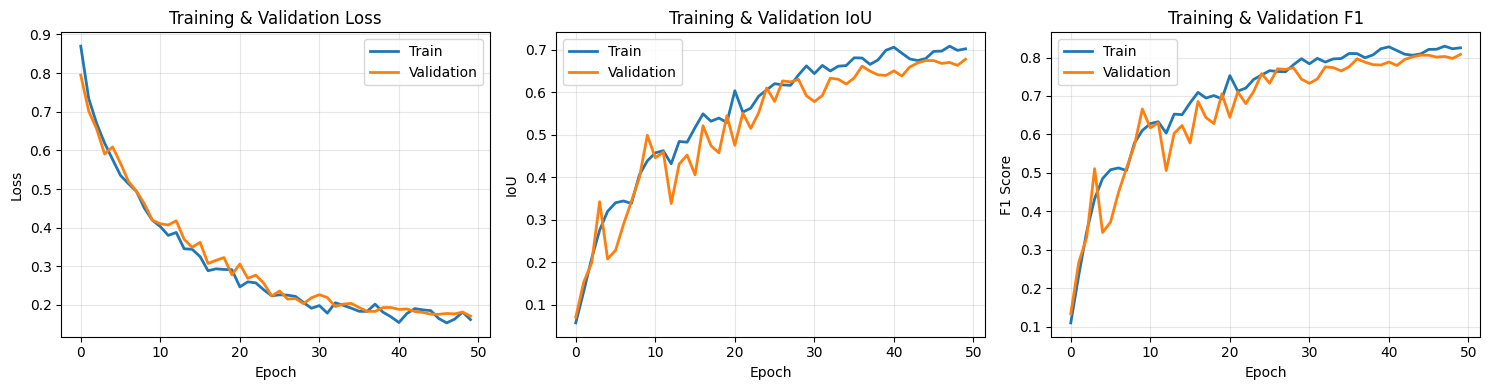

✓ Training curves saved to checkpoints/unet_baseline_resnet34_training_curves.png


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history["train_loss"], label="Train", linewidth=2)
axes[0].plot(history["val_loss"], label="Validation", linewidth=2)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU
axes[1].plot(history["train_iou"], label="Train", linewidth=2)
axes[1].plot(history["val_iou"], label="Validation", linewidth=2)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].set_title("Training & Validation IoU")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1
axes[2].plot(history["train_f1"], label="Train", linewidth=2)
axes[2].plot(history["val_f1"], label="Validation", linewidth=2)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("F1 Score")
axes[2].set_title("Training & Validation F1")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/{EXPERIMENT_NAME}_training_curves.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training curves saved to {SAVE_DIR}/{EXPERIMENT_NAME}_training_curves.png")


## 10. Evaluate on Test Set


In [ ]:
# Load best model
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate on test set
model.eval()
test_metrics = ChangeDetectionMetrics()

with torch.no_grad():
    for img_a, img_b, target in tqdm(loaders["test"], desc="Testing"):
        img_a = img_a.to(device)
        img_b = img_b.to(device)
        target = target.to(device)

        if target.dim() == 3:
            target = target.unsqueeze(1)

        pred = model(img_a, img_b)
        test_metrics.update(pred, target)

results = test_metrics.compute()

print("\n" + "=" * 50)
print("TEST SET RESULTS")
print("=" * 50)
print(f"Model:      {MODEL_NAME}")
print(f"Encoder:    {ENCODER_NAME}")
print("-" * 50)
print(f"IoU:        {results['iou']:.4f}")
print(f"F1 Score:   {results['f1']:.4f}")
print(f"Precision:  {results['precision']:.4f}")
print(f"Recall:     {results['recall']:.4f}")
print("=" * 50)


Loaded best model from epoch 50


Testing:   0%|          | 0/16 [00:00<?, ?it/s]


TEST SET RESULTS
Model:      unet_baseline
Encoder:    resnet34
--------------------------------------------------
IoU:        0.6753
F1 Score:   0.8062
Precision:  0.8333
Recall:     0.7808


## 11. Visualize Predictions


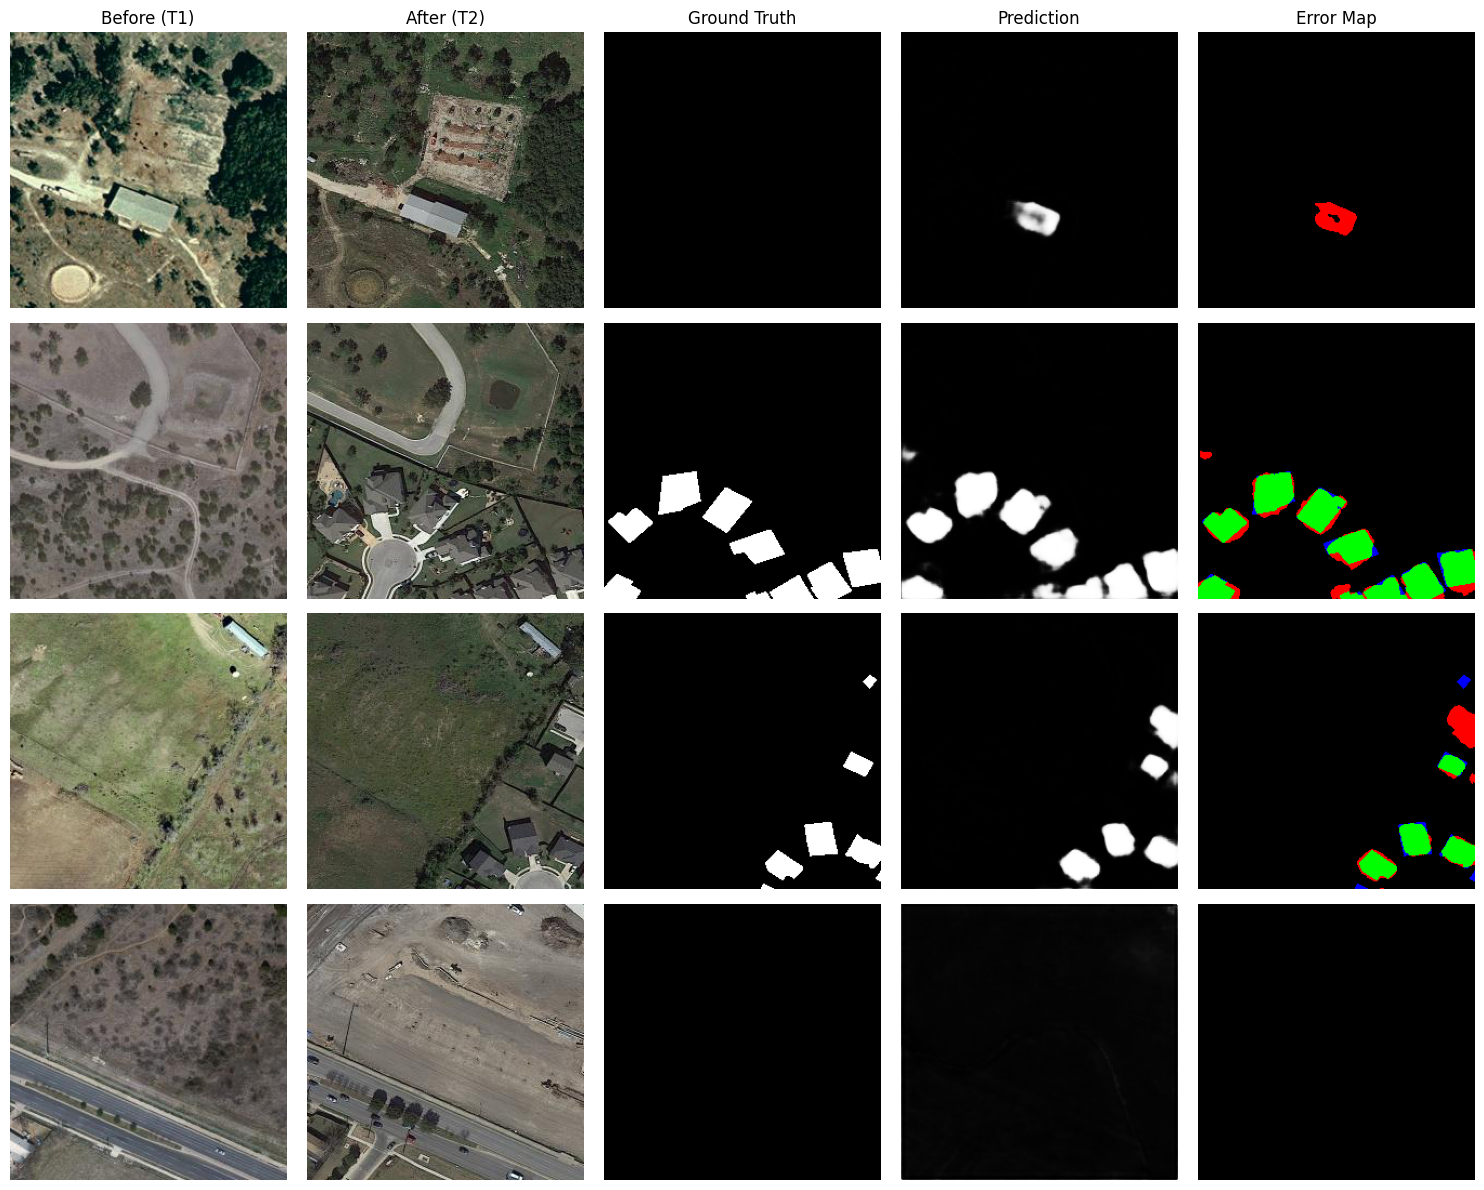

✓ Predictions saved to checkpoints/unet_baseline_resnet34_predictions.png


In [ ]:
def visualize_predictions(model, dataloader, device, num_samples=4):
    """Visualize model predictions vs ground truth."""
    model.eval()

    # Get a batch
    img_a, img_b, target = next(iter(dataloader))
    img_a = img_a.to(device)
    img_b = img_b.to(device)

    with torch.no_grad():
        pred = model(img_a, img_b)
        pred = torch.sigmoid(pred)

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    img_a_vis = img_a * std + mean
    img_b_vis = img_b * std + mean

    # Plot
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3*num_samples))

    for i in range(min(num_samples, img_a.shape[0])):
        # Before image
        axes[i, 0].imshow(img_a_vis[i].cpu().permute(1, 2, 0).clamp(0, 1))
        axes[i, 0].set_title("Before (T1)" if i == 0 else "")
        axes[i, 0].axis("off")

        # After image
        axes[i, 1].imshow(img_b_vis[i].cpu().permute(1, 2, 0).clamp(0, 1))
        axes[i, 1].set_title("After (T2)" if i == 0 else "")
        axes[i, 1].axis("off")

        # Ground truth - handle different tensor shapes
        gt_img = target[i].cpu()
        if gt_img.dim() == 3:  # (C, H, W)
            gt_img = gt_img[0]  # Take first channel
        elif gt_img.dim() == 1:  # Something wrong, reshape
            size = int(np.sqrt(gt_img.shape[0]))
            gt_img = gt_img.reshape(size, size)
        # Now gt_img should be (H, W)

        axes[i, 2].imshow(gt_img.numpy(), cmap="gray")
        axes[i, 2].set_title("Ground Truth" if i == 0 else "")
        axes[i, 2].axis("off")

        # Prediction
        pred_img = pred[i, 0].cpu()
        axes[i, 3].imshow(pred_img.numpy(), cmap="gray")
        axes[i, 3].set_title("Prediction" if i == 0 else "")
        axes[i, 3].axis("off")

        # Overlay (Green=TP, Red=FP, Blue=FN)
        gt = gt_img.numpy() > 0.5
        pr = pred_img.numpy() > 0.5

        overlay = np.zeros((*gt.shape, 3))
        overlay[gt & pr] = [0, 1, 0]  # TP: Green
        overlay[pr & ~gt] = [1, 0, 0]  # FP: Red
        overlay[gt & ~pr] = [0, 0, 1]  # FN: Blue

        axes[i, 4].imshow(overlay)
        axes[i, 4].set_title("Error Map" if i == 0 else "")
        axes[i, 4].axis("off")

    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/{EXPERIMENT_NAME}_predictions.png", dpi=150, bbox_inches='tight')
    plt.show()

# Visualize predictions on test set
visualize_predictions(model, loaders["test"], device, num_samples=4)
print(f"✓ Predictions saved to {SAVE_DIR}/{EXPERIMENT_NAME}_predictions.png")

## 12. Ablation Study: Compare Encoders

Run this section to train and compare different encoder backbones:
- ResNet34
- ResNet50
- EfficientNet-B0


In [ ]:
# Ablation Study: Compare different encoders
# NOTE: This will take a long time - run each experiment separately if needed

ENCODERS_TO_TEST = ["resnet34", "resnet50", "efficientnet-b0"]
ABLATION_EPOCHS = 30  # Reduce epochs for faster comparison

ablation_results = []

for encoder in ENCODERS_TO_TEST:
    print(f"\n{'='*60}")
    print(f"Training with encoder: {encoder}")
    print(f"{'='*60}")

    # Create model with this encoder
    ablation_model = get_model("unet_baseline", encoder_name=encoder, pretrained=True)
    ablation_model = ablation_model.to(device)

    # Count parameters
    params = sum(p.numel() for p in ablation_model.parameters())
    print(f"Parameters: {params:,}")

    # Setup training
    ablation_criterion = BCEDiceLoss()
    ablation_optimizer = optim.AdamW(ablation_model.parameters(), lr=LEARNING_RATE)
    ablation_scheduler = optim.lr_scheduler.CosineAnnealingLR(
        ablation_optimizer, T_max=ABLATION_EPOCHS
    )

    best_ablation_iou = 0

    # Training loop
    for epoch in range(1, ABLATION_EPOCHS + 1):
        train_loss, train_metrics = train_one_epoch(
            ablation_model, loaders["train"], ablation_criterion,
            ablation_optimizer, device, epoch
        )
        val_loss, val_metrics = validate(
            ablation_model, loaders["val"], ablation_criterion, device, epoch
        )
        ablation_scheduler.step()

        if val_metrics["iou"] > best_ablation_iou:
            best_ablation_iou = val_metrics["iou"]
            # Save best model for this encoder
            torch.save(
                ablation_model.state_dict(),
                f"{SAVE_DIR}/unet_{encoder}_best.pth"
            )

    # Evaluate on test set
    ablation_model.load_state_dict(torch.load(f"{SAVE_DIR}/unet_{encoder}_best.pth"))
    ablation_model.eval()
    test_metrics_ablation = ChangeDetectionMetrics()

    with torch.no_grad():
        for img_a, img_b, target in loaders["test"]:
            img_a, img_b = img_a.to(device), img_b.to(device)
            target = target.to(device)
            if target.dim() == 3:
                target = target.unsqueeze(1)
            pred = ablation_model(img_a, img_b)
            test_metrics_ablation.update(pred, target)

    test_results = test_metrics_ablation.compute()

    ablation_results.append({
        "encoder": encoder,
        "params": params,
        "iou": test_results["iou"],
        "f1": test_results["f1"],
        "precision": test_results["precision"],
        "recall": test_results["recall"]
    })

    print(f"\n{encoder} Test Results:")
    print(f"  IoU: {test_results['iou']:.4f}, F1: {test_results['f1']:.4f}")

# Print comparison table
print("\n" + "=" * 70)
print("ENCODER COMPARISON RESULTS")
print("=" * 70)
print(f"{'Encoder':<20} {'Params':<12} {'IoU':<10} {'F1':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 70)
for r in ablation_results:
    print(f"{r['encoder']:<20} {r['params']:<12,} {r['iou']:<10.4f} {r['f1']:<10.4f} {r['precision']:<10.4f} {r['recall']:<10.4f}")
print("=" * 70)



Training with encoder: resnet34
Parameters: 24,445,777


Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


resnet34 Test Results:
  IoU: 0.6329, F1: 0.7752

Training with encoder: resnet50


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Parameters: 32,530,513


Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


resnet50 Test Results:
  IoU: 0.6654, F1: 0.7991

Training with encoder: efficientnet-b0


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Parameters: 6,252,333


Epoch 1 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30 [Train]:   0%|          | 0/56 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/8 [00:00<?, ?it/s]


efficientnet-b0 Test Results:
  IoU: 0.5714, F1: 0.7273

ENCODER COMPARISON RESULTS
Encoder              Params       IoU        F1         Precision  Recall    
----------------------------------------------------------------------
resnet34             24,445,777   0.6329     0.7752     0.8069     0.7459    
resnet50             32,530,513   0.6654     0.7991     0.7901     0.8083    
efficientnet-b0      6,252,333    0.5714     0.7273     0.7288     0.7257    


## 13. Save Results to Google Drive


In [ ]:
# Copy checkpoints and results to Google Drive for persistence
import shutil

# Create directory in Google Drive
GDRIVE_SAVE_DIR = "/content/drive/MyDrive/DL_Project/maggie_baseline"
os.makedirs(GDRIVE_SAVE_DIR, exist_ok=True)

# Copy all checkpoints and results
for file in os.listdir(SAVE_DIR):
    src = os.path.join(SAVE_DIR, file)
    dst = os.path.join(GDRIVE_SAVE_DIR, file)
    shutil.copy2(src, dst)
    print(f"Copied: {file}")

print(f"\n✓ All results saved to Google Drive: {GDRIVE_SAVE_DIR}")
print("\nFiles saved:")
for f in os.listdir(GDRIVE_SAVE_DIR):
    print(f"  - {f}")


Copied: unet_resnet50_best.pth
Copied: unet_baseline_resnet34_best.pth
Copied: unet_resnet34_best.pth
Copied: unet_efficientnet-b0_best.pth
Copied: unet_baseline_resnet34_predictions.png
Copied: unet_baseline_resnet34_training_curves.png

✓ All results saved to Google Drive: /content/drive/MyDrive/DL_Project/maggie_baseline

Files saved:
  - unet_resnet50_best.pth
  - unet_baseline_resnet34_best.pth
  - unet_resnet34_best.pth
  - unet_efficientnet-b0_best.pth
  - unet_baseline_resnet34_predictions.png
  - unet_baseline_resnet34_training_curves.png


## 📊 Project Summary

---

### 🏙️ Urban Change Detection Using U-Net Baseline
**Author:** Maggie Tu  
**Task:** Detect building changes between satellite images from two different time periods using the LEVIR-CD dataset.

---

### 🔬 Experiment Overview

| Aspect | Details |
|--------|---------|
| **Dataset** | LEVIR-CD (256×256 patches) |
| **Training Samples** | 445 |
| **Validation Samples** | 64 |
| **Test Samples** | 128 |
| **Training Epochs** | 50 |
| **Batch Size** | 8 |
| **Learning Rate** | 1e-4 |
| **Loss Function** | BCE + Dice Loss (50/50 weighted) |
| **Optimizer** | AdamW with Cosine Annealing LR |

---

### 🏆 Main Model Performance (U-Net Baseline + ResNet34)

| Metric | Test Set Score |
|--------|----------------|
| **IoU (Jaccard)** | **0.6753** |
| **F1 Score** | **0.8062** |
| **Precision** | 0.8333 |
| **Recall** | 0.7808 |

- **Model Parameters:** 24,445,777 (~24.4M)
- **Best Checkpoint:** Epoch 50

---

### 📈 Encoder Ablation Study Results (30 epochs)

| Encoder | Parameters | IoU | F1 Score | Precision | Recall |
|---------|------------|-----|----------|-----------|--------|
| **ResNet50** | 32.5M | **0.6654** | **0.7991** | 0.7901 | **0.8083** |
| ResNet34 | 24.4M | 0.6329 | 0.7752 | **0.8069** | 0.7459 |
| EfficientNet-B0 | 6.3M | 0.5714 | 0.7273 | 0.7288 | 0.7257 |

**Key Findings:**
- **ResNet50** achieved the best IoU (0.6654) and recall (0.8083), making it the top performer
- **ResNet34** offers a good balance between performance and efficiency with the highest precision
- **EfficientNet-B0** is the most lightweight (6.3M params) but shows lower performance, suggesting change detection benefits from larger model capacity

---

### 💡 Key Takeaways

1. **U-Net Architecture Effectiveness:** The concatenation approach (T1 + T2 → 6 channels) works well for change detection tasks

2. **Encoder Impact:** Deeper encoders (ResNet50 > ResNet34 > EfficientNet-B0) generally improve performance, though with diminishing returns relative to parameter increase

3. **Training Stability:** The model showed consistent improvement throughout 50 epochs with best validation IoU achieved at final epoch

4. **Class Imbalance Handling:** Combined BCE + Dice loss effectively handles the imbalanced nature of change detection (fewer changed pixels)

5. **Precision vs Recall Trade-off:** ResNet34 favors precision (fewer false positives) while ResNet50 favors recall (detecting more actual changes)

---

### 🚀 Future Improvements

- Experiment with **U-Net++** and **DeepLabV3+** architectures (already implemented)
- Try attention mechanisms (e.g., CBAM, SE blocks)
- Implement test-time augmentation (TTA) for improved predictions
- Explore transformer-based backbones (e.g., Swin Transformer)
- Fine-tune with larger image sizes (512×512)

---

*Generated: December 2024*
